# **Music Recommendation System**

## **Problem Definition**

**The context** - Why is this problem important to solve?<br>
**The objectives** - What is the intended goal?<br>
**The key questions** - What are the key questions that need to be answered?<br>
**The problem formulation** - What is it that we are trying to solve using data science?


## **Data Dictionary**

The core data is the Taste Profile Subset released by The Echo Nest as part of the Million Song Dataset. There are two files in this dataset. One contains the details about the song id, titles, release, artist name and the year of release. Second file contains the user id, song id and the play count of users.

song_data

song_id - A unique id given to every song

title - Title of the song

Release - Name of the released album

Artist_name - Name of the artist 

year - Year of release

count_data

user _id - A unique id given to the user

song_id - A unique id given to the song

play_count - Number of times the song was played

## **Data Source**
http://millionsongdataset.com/

## **Important Notes**

- This notebook can be considered a guide to refer to while solving the problem. The evaluation will be as per the Rubric shared for each Milestone. Unlike previous courses, it does not follow the pattern of the graded questions in different sections. This notebook would give you a direction on what steps need to be taken in order to get a viable solution to the problem. Please note that this is just one way of doing this. There can be other 'creative' ways to solve the problem and we urge you to feel free and explore them as an 'optional' exercise. 

- In the notebook, there are markdown cells called - Observations and Insights. It is a good practice to provide observations and extract insights from the outputs.

- The naming convention for different variables can vary. Please consider the code provided in this notebook as a sample code.

- All the outputs in the notebook are just for reference and can be different if you follow a different approach.

- There are sections called **Think About It** in the notebook that will help you get a better understanding of the reasoning behind a particular technique/step. Interested learners can take alternative approaches if they want to explore different techniques. 

### **Importing Libraries and the Dataset**

In [ ]:
#Mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import warnings #Used to ignore the warning given as output of the code.
warnings.filterwarnings('ignore')

import numpy as np # Basic libraries of python for numeric and dataframe computations.
import pandas as pd

import matplotlib.pyplot as plt #Basic library for data visualization.
import seaborn as sns #Slightly advanced library for data visualization

from sklearn.metrics.pairwise import cosine_similarity #To compute the cosine similarity between two vectors.
from collections import defaultdict #A dictionary output that does not raise a key error

from sklearn.metrics import mean_squared_error # A performance metrics in sklearn.
from sklearn.preprocessing import LabelEncoder  # To do label encoding

In [ ]:
#importing the datasets
count_df = pd.read_csv('/content/drive/MyDrive/count_data.csv')
song_df = pd.read_csv('/content/drive/MyDrive/song_data.csv')

### **Understanding the data by viewing a few observations**

In [ ]:
# See top 10 records of count_df data

most_rated_count = count_df.groupby('song_id').size().sort_values(ascending = False)[:10]

most_rated_count

song_id
SOFRQTD12A81C233C0    8277
SOAUWYT12A81C206F1    7032
SOAXGDH12A8C13F8A1    6949
SOBONKR12A58A7A7E0    6412
SOSXLTC12AF72A7F54    6145
SONYKOW12AB01849C9    5841
SOEGIYH12A6D4FC0E3    5385
SOLFXKT12AB017E3E0    4795
SODJWHY12A8C142CCE    4758
SOFLJQZ12A6D4FADA6    4548
dtype: int64

In [ ]:
# See top 10 records of song_df data

most_rated_song = song_df.groupby('song_id').size().sort_values(ascending = False)[:10]

most_rated_song

song_id
SOUYQYY12AF72A000F    3
SOLNCTS12A8C1405EF    3
SOQNMCD12A8C1383D4    3
SOBPAEP12A58A77F49    3
SOVASUH12A67021B44    3
SOPRYHK12A8AE47858    3
SOPOCDY12A8C13F75A    3
SOFBCSG12AAF3B2AA0    3
SOKBIIQ12AB017FEFC    3
SOTPHGF12A8C142844    3
dtype: int64

### **Let us check the data types and and missing values of each column**

In [ ]:
# See the info of the count_df data

count_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 4 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   Unnamed: 0  int64 
 1   user_id     object
 2   song_id     object
 3   play_count  int64 
dtypes: int64(2), object(2)
memory usage: 61.0+ MB


In [ ]:
# See the info of the song_df data

song_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 5 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   song_id      1000000 non-null  object
 1   title        999985 non-null   object
 2   release      999995 non-null   object
 3   artist_name  1000000 non-null  object
 4   year         1000000 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 38.1+ MB


#### **Observations and Insights:**

- In the count dataframe, we have a column is data that we could drop since it is not useful to us
- The dtypes for the columns are all objects with the exception of year which is an integer in the song df and in count df all are objects with the exception of the play counts
- We have some missing values in title and release in the song_df 


In [ ]:
# Left merge the count_df and song_df data on "song_id". Drop duplicates from song_df data simultaneously.

df = pd.merge(count_df,song_df,on='song_id', how='left')

# Drop the column 'Unnamed: 0'

df = df.drop('Unnamed: 0', axis = 1)

**Think About It:** As the user_id and song_id are encrypted. Can they be encoded to numeric features?

In [ ]:
# Apply label encoding for "user_id" and "song_id"
le = LabelEncoder()

df['user_id'] = le.fit_transform(df['user_id'])
df['song_id'] = le.fit_transform(df['song_id'])

**Think About It:** As the data also contains users who have listened to very few songs and vice versa, is it required to filter the data so that it contains users who have listened to a good count of songs and vice versa?

In [ ]:
# Get the column containing the users
users = df.user_id
# Create a dictionary from users to their number of songs
ratings_count = dict()
for user in users:
    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1
    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1    

In [ ]:
# We want our users to have listened at least 90 songs
RATINGS_CUTOFF = 90
remove_users = []
for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)
df = df.loc[~df.user_id.isin(remove_users)]

In [ ]:
# Get the column containing the songs
songs = df.song_id
# Create a dictionary from songs to their number of users
ratings_count = dict()
for song in songs:
    # If we already have the song, just add 1 to their rating count
    if song in ratings_count:
        ratings_count[song] += 1
    # Otherwise, set their rating count to 1
    else:
        ratings_count[song] = 1    

In [ ]:
# We want our song to be listened by atleast 120 users to be considred
RATINGS_CUTOFF = 120
remove_songs = []
for song, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_songs.append(song)
df_final= df.loc[~df.song_id.isin(remove_songs)]

In [ ]:
# Drop records with play_count more than(>) 5

df_final.drop(df_final[df_final['play_count'] > 5].index, inplace = True)

In [ ]:
# Check the shape of the data
df_final.shape

(154377, 7)

## **Exploratory Data Analysis**

### **Let's check the total number of unique users, songs, artists in the data**

Total number of unique user id

In [ ]:
# Display total number of unique user_id

df_final['user_id'].nunique()

3476

Total number of unique song id

In [ ]:
# Display total number of unique song_id
df_final['song_id'].nunique()

695

Total number of unique artists

In [ ]:
# Display total number of unique artists
df['artist_name'].nunique()

3379

#### **Observations and Insights:**

- There are 3476 total unique users
- There are 695 total unique songs
- There are 3379 total unique artists


### **Let's find out about the most interacted songs and interacted users**

Most interacted songs

In [ ]:
most_interacted_songs = df_final.groupby('song_id').size().sort_values(ascending = False)[:10]
most_interacted_songs

song_id
8582    1652
6293    1294
3567    1014
4270     975
1286     940
310      926
7796     924
5291     850
7998     844
352      821
dtype: int64

Most interacted users

In [ ]:
most_interacted_users = df_final.groupby('user_id').size().sort_values(ascending = False)[:10]
most_interacted_users

user_id
61472    311
37049    267
15733    243
75144    237
9570     212
10763    210
23337    204
31704    201
43041    200
37851    197
dtype: int64

#### **Observations and Insights:**

- Song ID 8582 is the most interacted song with 1652 interactions
- User ID 61472 is the most interacted user with 311 interactions


Songs played in a year

In [ ]:
count_songs = df_final.groupby('year').count()['title']
count = pd.DataFrame(count_songs)
count.drop(count.index[0], inplace=True)
count.tail()

,title
year,
2006,9515
2007,17510
2008,18619
2009,19856
2010,5541


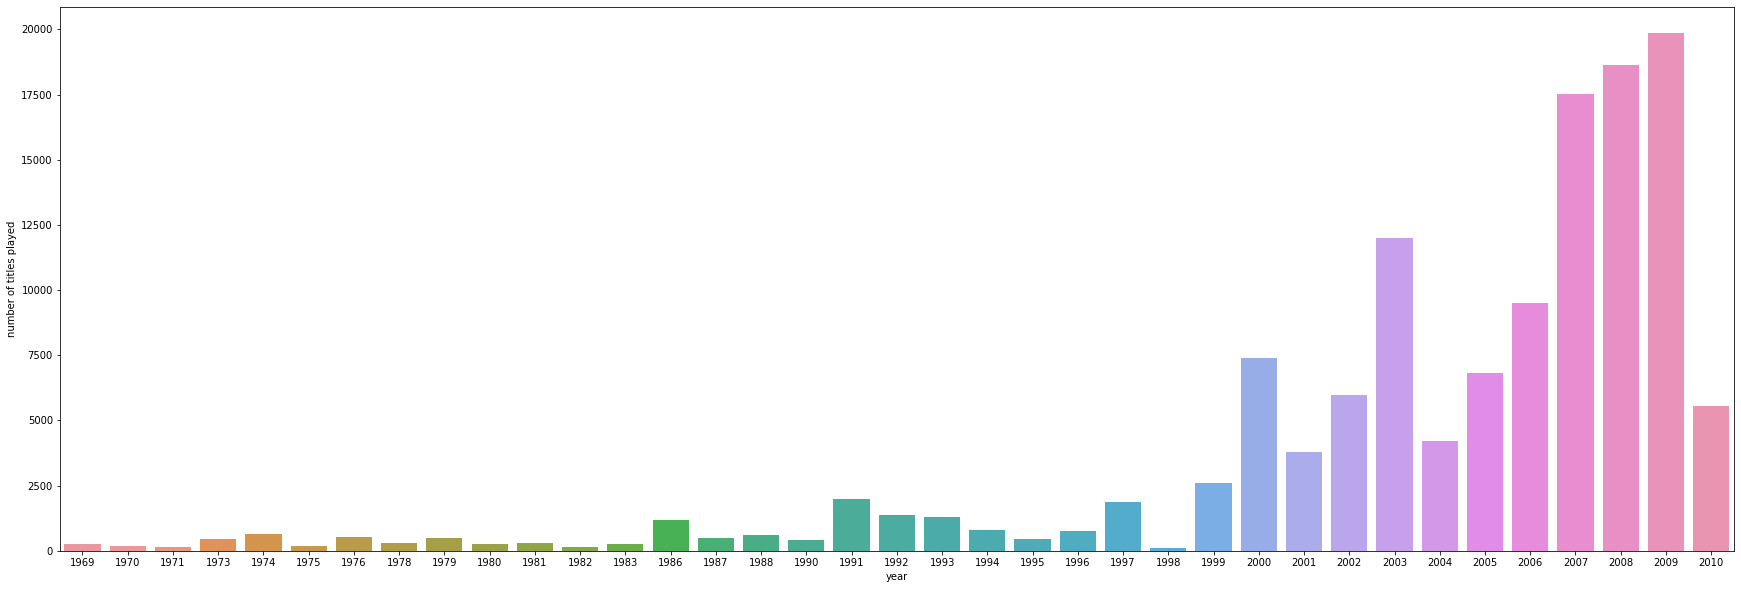

In [ ]:
plt.figure(figsize=(30,10))
sns.barplot(x = count.index,
            y = 'title',
            data = count,
            estimator = np.median)
plt.ylabel('number of titles played') 
# Show the plot
plt.show()

#### **Observations and Insights:**

- Based on the bar plot above, 2009 had the most number of titles played 
- We see a huge decrease from 2009 to 2010 so it would be interesting to see what caused that decrease
- Additionally, we see a huge decrease from 2003 to 2004 and 2000 to 2001 so it would be good to see if the same variables that cause the decrease from 2009 to 2010 were similar to previous years

**Think About It:** What other insights can be drawn using exploratory data analysis?

## **Proposed approach**
**Potential techniques** - What different techniques should be explored?<br>
**Overall solution design** - What is the potential solution design?<br>
**Measures of success**- What are the key measures of success to compare different potential technqiues?<br>

Potential techniques for building the music recommendations system can be the ranked approach using counts, user-user similarity-based collaborative fitlering, item-item similarity-based collaborative fitlering, and model-based collaborative filtering (matrix factorization).

The potential solution design can be utilizing parameters from GridSearchCV to build opimized models from the potential techniques. Also utilizing cross-validation to tune values of the hyperparameters.

KPIs to measure the success of each model are the the F_1 Score, Recall, Precision, and RMSE. Additionally, r_ui when we opimize the hyperparameter.


Now that we have explored the data, let's apply different algorithms to build recommendation systems

**Note:** Use the shorter version of the data i.e. the data after the cutoffs as used in Milestone 1.

### **Popularity-Based Recommendation Systems**

Let's take the count and sum of play counts of the songs and build the popularity recommendation systems on the basis of the sum of play counts.

In [ ]:
#Calculating average play_count
average_count = df_final.groupby('song_id').mean()['play_count'] #Hint: Use groupby function on the song_id column.

#Calculating the frequency a song is played.
play_freq = df_final.groupby('song_id').count()['play_count']#Hint: Use groupby function on the song_id column

In [ ]:
#Making a dataframe with the average_count and play_freq
final_play = pd.DataFrame({'avg_count':average_count, 'play_freq':play_freq})
final_play.head()

,avg_count,play_freq
song_id,,
21,1.635714,280
22,1.454545,143
50,1.618182,110
52,1.719565,460
62,1.731707,123


Now, let's create a function to find the top n songs for a recommendation based on the average play count of song. We can also add a threshold for a minimum number of playcounts for a song to be considered for recommendation.

In [ ]:
#Build the function for finding top n songs

def top_n_songs(data, n, min_interaction = 100):

  # Finding song with minimum number of interactions
  recommendations = data[data['play_freq'] > min_interaction]

  # Sorting values with respect to average counts
  recommendations = recommendations.sort_values(by = 'avg_count', ascending = False)
  return recommendations.index[:n]

In [ ]:
#Recommend top 10 songs using the function defined above

list(top_n_songs(final_play, 10, 100))

[7224, 8324, 6450, 9942, 5531, 8483, 657, 5653, 614, 2220]

### User User Similarity-Based Collaborative Filtering

To build the user-user-similarity based and subsequent models we will use the "surprise" library.

In [ ]:
#Install the surprise package using pip. Uncomment and run the below code to do the same. 
!pip install surprise 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.8 MB 3.7 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1633722 sha256=5ec62eb4f0e043913410a79cb7699f14f457536c6118a1043a33b7eb33f0b848
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [ ]:
# Import necessary libraries
# To compute the accuracy of models
from surprise import accuracy

# class is used to parse a file containing play_counts, data should be in structure - user; item ; play_count
from surprise.reader import Reader

# class for loading datasets
from surprise.dataset import Dataset

# for tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# for splitting the data in train and test dataset
from surprise.model_selection import train_test_split

# for implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# for implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing KFold cross-validation
from surprise.model_selection import KFold

#For implementing clustering-based recommendation system
from surprise import CoClustering

#### Some useful functions

The below is the function to calculate precision@k and recall@k, RMSE and F1_Score@k to evaluate the model performance.

**Think About It:** Which metric should be used for this problem to compare different models?

In [ ]:
#The function to calulate the RMSE, precision@k, recall@k and F_1 score. 
def precision_recall_at_k(model, k=30, threshold=1.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    
    #Making predictions on the test data
    predictions=model.test(testset)
    
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set Precision to 0 when n_rec_k is 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set Recall to 0 when n_rel is 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
    
    #Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)),3)
    #Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)),3)
    
    accuracy.rmse(predictions)
    print('Precision: ', precision) #Command to print the overall precision
    print('Recall: ', recall) #Command to print the overall recall
    print('F_1 score: ', round((2*precision*recall)/(precision+recall),3)) # Formula to compute the F-1 score.

**Think About It:** In the function precision_recall_at_k above the threshold value used is 1.5. How precision and recall are affected by chaning the threshold? What is the intuition behind using the threshold value 1.5? 

In [ ]:
# Instantiating Reader scale with expected rating scale 
reader = Reader(rating_scale=(0,5)) #use rating scale (0,5)

# loading the dataset
data = Dataset.load_from_df(df_final[["user_id", "song_id", "play_count"]], reader) #Take only "user_id","song_id", and "play_count"

# splitting the data into train and test dataset
trainset, testset = train_test_split(data, test_size= 0.4, random_state=42) # Take test_size=0.4

**Think About It:** How changing the test size would change the results and outputs?

In [ ]:
#Build the default user-user-similarity model
sim_options = {'name': 'cosine',
               'user_based': True}

#KNN algorithm is used to find desired similar items.
sim_user_user = KNNBasic(sim_options = sim_options, verbose = False, random_state = 1) #use random_state=1 

# Train the algorithm on the trainset, and predict play_count for the testset
sim_user_user.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score with k =30.
precision_recall_at_k(sim_user_user) #Use sim_user_user model

RMSE: 1.0611
Precision:  0.405
Recall:  0.711
F_1 score:  0.516


**Observations and Insights:**

- The model isn't performing well because the precision, recall, and F_1 scores are all lower. Hypertuning the parameter we should be able to increase these.

In [ ]:
#predicting play_count for a sample user with a listened song.
sim_user_user.predict(6958, 1671, r_ui=2, verbose=True) #use user id 6958 and song_id 1671

user: 6958       item: 1671       r_ui = 2.00   est = 1.83   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=6958, iid=1671, r_ui=2, est=1.8256312668335963, details={'actual_k': 40, 'was_impossible': False})

In [ ]:
#predicting play_count for a sample user with a song not-listened by the user.
sim_user_user.predict(6958,3232, verbose=True) #Use user_id 6958 and song_id 3232

user: 6958       item: 3232       r_ui = None   est = 1.61   {'actual_k': 33, 'was_impossible': False}


Prediction(uid=6958, iid=3232, r_ui=None, est=1.6118677152959722, details={'actual_k': 33, 'was_impossible': False})

**Observations and Insights:**

- The estiimation is 1.61 and r_ui is 2 which is a significant difference for song 3232
- Acutal_k for song 1671 is higher than song 3232
- Tuning the hyper parameter might be able to increase these values

Now, let's try to tune the model and see if we can improve the model performance.

In [ ]:
# setting up parameter grid to tune the hyperparameters
param_grid = {'k': [10, 20, 30], 'min_k': [3, 6, 9],
              'sim_options': {'name': ["cosine",'pearson',"pearson_baseline"],
                              'user_based': [True], "min_support":[2,4]}
              }

# performing 3-fold cross validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

# fitting the data
gs.fit(data) #Use entire data for GridSearch

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])


0.9774595234041422
{'k': 30, 'min_k': 9, 'sim_options': {'name': 'pearson_baseline', 'user_based': True, 'min_support': 2}}


In [ ]:
# Train the best model found in above gridsearch.
sim_options = {'name': 'pearson_baseline',
               'user_based': True}

# Creating an instance of KNNBasic with optimal hyperparameter values
sim_user_user_optimized = KNNBasic(sim_options = sim_options, k = 30, min_k = 9, random_state = 1, verbose = False)

# Training the algorithm on the trainset
sim_user_user_optimized.fit(trainset)

# Let us compute precision@k and recall@k also with k = 10
precision_recall_at_k(sim_user_user_optimized)

RMSE: 0.9831
Precision:  0.452
Recall:  0.744
F_1 score:  0.562


**Observations and Insights:**

- We used four different techniques to tune the hyper parameter :

 - **cosine**  -
  RMSE: 1.0668
Precision:  0.402
Recall:  0.691
F_1 score:  0.508

 - **msd** - 
 RMSE: 0.9946
Precision:  0.453
Recall:  0.63
F_1 score:  0.527

 - **pearson** - 
 RMSE: 1.0264
Precision:  0.416
Recall:  0.818
F_1 score:  0.552

 - **pearson_baseline** - 
 RMSE: 0.9831
Precision:  0.452
Recall:  0.744
F_1 score:  0.562

- Based on the model results, we can conclude that pearson_baseline the best out of all other techniques with the highest precision and F_1 score.

In [ ]:
#Predict the play count for a user who has listened to the song. Take user_id 6958, song_id 1671 and r_ui=2
sim_user_user_optimized.predict(6958, 1671, r_ui = 2, verbose = True)

user: 6958       item: 1671       r_ui = 2.00   est = 1.97   {'actual_k': 27, 'was_impossible': False}


Prediction(uid=6958, iid=1671, r_ui=2, est=1.9674556802913845, details={'actual_k': 27, 'was_impossible': False})

In [ ]:
#Predict the play count for a song that is not listened by the user (with user_id 6958)
sim_user_user_optimized.predict(6958, 3232, verbose = True)

user: 6958       item: 3232       r_ui = None   est = 1.86   {'actual_k': 10, 'was_impossible': False}


Prediction(uid=6958, iid=3232, r_ui=None, est=1.8558648047903226, details={'actual_k': 10, 'was_impossible': False})

**Observations and Insights:**

- We do see an increase in the estimated value and acutal_k for the hypertuned model.
- Song 1671 est is closer to r_ui compared to the base model

**Think About It:** Along with making predictions on listened and unknown songs can we get 5 nearest neighbors (most similar) to a certain user?

In [ ]:
#Use inner id 0. 

sim_user_user_optimized.get_neighbors(0, 5)

[907, 576, 1667, 2590, 996]

Below we will be implementing a function where the input parameters are -

- data: a song dataset
- user_id: a user id against which we want the recommendations
- top_n: the number of songs we want to recommend
- algo: the algorithm we want to use for predicting the play_count
- The output of the function is a set of top_n items recommended for the given user_id based on the given algorithm

In [ ]:
def get_recommendations(data, user_id, top_n, algo):
    
    # creating an empty list to store the recommended product ids
    recommendations = []
    
    # creating an user item interactions matrix 
    user_item_interactions_matrix = data.pivot_table(index = 'user_id', columns = 'song_id', values = 'play_count')
    
    # extracting those business ids which the user_id has not visited yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()
    
    # looping through each of the business ids which user_id has not interacted yet
    for item_id in non_interacted_products:
        
        # predicting the ratings for those non visited restaurant ids by this user
        est = algo.predict(user_id, item_id).est
        
        # appending the predicted ratings
        recommendations.append((item_id, est))

    # sorting the predicted ratings in descending order
    recommendations.sort(key=lambda x: x[1], reverse=True)

    return recommendations[:top_n] # returing top n highest predicted rating products for this user

In [ ]:
#Make top 5 recommendations for user_id 6958 with a similarity-based recommendation engine.
recommendations = get_recommendations(df_final, 6958, 5, sim_user_user)

In [ ]:
#Building the dataframe for above recommendations with columns "song_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns = ['song_id', 'predicted_ratings'])

,song_id,predicted_ratings
0,7224,3.666771
1,6450,3.173413
2,8324,3.006556
3,8483,2.692783
4,8863,2.433057


**Observations and Insights:**
- The above table are the recommendations for previous executed model
- We do not see the play_count in the table so we should correct that

#### **Correcting the play_counts and Ranking the above songs**

In [ ]:
def ranking_songs(recommendations, final_rating):
  # sort the songs based on play counts
  ranked_songs = final_rating.loc[[items[0] for items in recommendations]].sort_values('play_freq', ascending=False)[['play_freq']].reset_index()

  # merge with the recommended songs to get predicted play_count
  ranked_songs = ranked_songs.merge(pd.DataFrame(recommendations, columns=['song_id', 'predicted_ratings']), on='song_id', how='inner')

  # rank the songs based on corrected play_counts
  ranked_songs['corrected_ratings'] = ranked_songs['predicted_ratings'] - 1 / np.sqrt(ranked_songs['play_freq'])

  # sort the songs based on corrected play_counts
  ranked_songs = ranked_songs.sort_values('corrected_ratings', ascending = False)
  
  return ranked_songs

**Think About It:** In the above function to make the correction in the predicted play_count a quantity 1/np.sqrt(n) is subtracted. What is the intuition behind it? Is it also possible to add this quantity instead of subtracting?

In [ ]:
#Applying the ranking_songs function on the final_play data. 

ranking_songs(recommendations, final_play)

,song_id,play_freq,predicted_ratings,corrected_ratings
3,7224,111,3.666771,3.571856
2,6450,115,3.173413,3.080163
4,8324,103,3.006556,2.908023
0,8483,132,2.692783,2.605745
1,8863,124,2.433057,2.343254


**Observations and Insights:**

- We now have both predicted and corrected ratings so this is a better estimation of ranking_songs

### **Item Item Similarity-based collaborative filtering recommendation systems**

In [ ]:
#Apply the item-item similarity collaborative filtering model with random_state=1 and evaluate the model performance.
sim_options = {'name': 'cosine',
               'user_based': False}

# KNN algorithm is used to find desired similar items
sim_item_item = KNNBasic(sim_options = sim_options, random_state = 1, verbose = False)

# Train the algorithm on the trainset, and predict ratings for the testset
sim_item_item.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(sim_item_item)

RMSE: 1.0077
Precision:  0.313
Recall:  0.561
F_1 score:  0.402


**Observations and Insights:**

- The model isn't performing well because the precision, recall, and F_1 scores are all lower. Hypertuning the parameter we should be able to increase these.

In [ ]:
#predicting play count for a sample user_id 6958 and song (with song_id 1671) heard by the user.
sim_item_item.predict(6958, 1671, r_ui = 2, verbose = True)

user: 6958       item: 1671       r_ui = 2.00   est = 1.42   {'actual_k': 21, 'was_impossible': False}


Prediction(uid=6958, iid=1671, r_ui=2, est=1.4238426703016684, details={'actual_k': 21, 'was_impossible': False})

In [ ]:
#Predict the play count for a user that has not listened to the song (with song_id 1671)
sim_item_item.predict(6958, 1671, verbose = True)

user: 6958       item: 1671       r_ui = None   est = 1.42   {'actual_k': 21, 'was_impossible': False}


Prediction(uid=6958, iid=1671, r_ui=None, est=1.4238426703016684, details={'actual_k': 21, 'was_impossible': False})

**Observations and Insights:**

- The estimated value when compared to r_ui is dignificantly lower


*For some reason, all the other predicions for NOT listened to were with song_id 3232 and this one is song_1671 same as the song hear by user, below are observations for both*

*With song_id 1671*

```
user: 6958       item: 1671       r_ui = None   est = 1.42   {'actual_k': 21, 'was_impossible': False}
Prediction(uid=6958, iid=1671, r_ui=None, est=1.4238426703016684, details={'actual_k': 21, 'was_impossible': False})
```

*With song_id 3232 *

```
user: 6958       item: 3232       r_ui = None   est = 1.48   {'actual_k': 21, 'was_impossible': False}
Prediction(uid=6958, iid=3232, r_ui=None, est=1.4755602240054544, details={'actual_k': 21, 'was_impossible': False})
```

- Estimated value increased a little bit, but not enough. Actual_k is also lower.
- Hyper tuning the parameter should help this



In [ ]:
#Apply grid search for enhancing model performance

# setting up parameter grid to tune the hyperparameters
param_grid = {'k': [10, 20, 30], 'min_k': [3, 6, 9],
              'sim_options': {'name': ["cosine",'pearson',"pearson_baseline"],
                              'user_based': [False], "min_support":[2,4]}
              }

# performing 3-fold cross validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

# fitting the data
gs.fit(data)

# find best RMSE score
print(gs.best_score['rmse'])

# Extract the combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9611491219207151
{'k': 20, 'min_k': 3, 'sim_options': {'name': 'pearson_baseline', 'user_based': False, 'min_support': 2}}


**Think About It:** How do the parameters affect the performance of the model? Can we improve the performance of the model further? Check the list of hyperparameter here.

In [ ]:
#Apply the best modle found in the grid search.
sim_options = {'name': 'pearson_baseline',
               'user_based': False}

# Creating an instance of KNNBasic with optimal hyperparameter values
sim_item_item_optimized = KNNBasic(sim_options = sim_options, k = 20, min_k = 3, random_state = 1, verbose = False)

# Training the algorithm on the trainset
sim_item_item_optimized.fit(trainset)

# Let us compute precision@k and recall@k also with k = 10
precision_recall_at_k(sim_item_item_optimized)

RMSE: 0.9697
Precision:  0.468
Recall:  0.614
F_1 score:  0.531


**Observations and Insights:**

- We used four different techniques to tune the hyper parameter :

 - **cosine**  -
  RMSE: 1.0080
Precision:  0.333
Recall:  0.555
F_1 score:  0.416

 - **msd** - 
 RMSE: 0.9982
Precision:  0.365
Recall:  0.539
F_1 score:  0.435

 - **pearson** - 
 RMSE: 0.9997
Precision:  0.418
Recall:  0.6
F_1 score:  0.493

 - **pearson_baseline** - 
 RMSE: 0.9697
Precision:  0.468
Recall:  0.614
F_1 score:  0.531

- Based on the model results, we can conclude that pearson_baseline the best out of all other techniques with the highest precision and F_1 score.

In [ ]:
#Predict the play_count by a user(user_id 6958) for the song (song_id 1671)

sim_item_item_optimized.predict(6958, 1671, r_ui = 2, verbose = True)

user: 6958       item: 1671       r_ui = 2.00   est = 2.07   {'actual_k': 7, 'was_impossible': False}


Prediction(uid=6958, iid=1671, r_ui=2, est=2.0728310917959085, details={'actual_k': 7, 'was_impossible': False})

In [ ]:
#predicting play count for a sample user_id 6958 with song_id 3232 which is not heard by the user.

sim_item_item_optimized.predict(6958, 3232, verbose = True)

user: 6958       item: 3232       r_ui = None   est = 1.00   {'actual_k': 9, 'was_impossible': False}


Prediction(uid=6958, iid=3232, r_ui=None, est=1.0, details={'actual_k': 9, 'was_impossible': False})

**Observations and Insights:**

- By tuning the hyperparameter, we see an increase in the estimated values for song 1671 and a decrease for song 3232
- We also see a decrease in actual_k for both predictors

In [ ]:
#Find five most similar users to the user with inner id 0

sim_item_item_optimized.get_neighbors(0, k = 5)

[40, 59, 145, 52, 93]

In [ ]:
#Making top 5 recommendations for user_id 6958 with item_item_similarity-based recommendation engine.
recommendations = get_recommendations(df_final, 6958, 5, sim_item_item_optimized)

In [ ]:
#Building the dataframe for above recommendations with columns "song_id" and "predicted_play_count"
pd.DataFrame(recommendations, columns = ['song_id', 'predicted_ratings'])

,song_id,predicted_ratings
0,3466,3.429231
1,2234,3.372966
2,4806,3.286799
3,9076,3.122453
4,5398,3.015413


In [ ]:
#Applying the ranking_songs function. 

ranking_songs(recommendations, final_play)

,song_id,play_freq,predicted_ratings,corrected_ratings
4,3466,118,3.429231,3.337173
3,2234,154,3.372966,3.292383
1,4806,235,3.286799,3.221566
2,9076,156,3.122453,3.042389
0,5398,300,3.015413,2.957678


**Observations and Insights:**

- Displayed are the ranking songs based on recommendations
- Very similar recommendations as the user-user model

### **Model Based Collaborative Filtering - Matrix Factorization**

Model-based Collaborative Filtering is a personalized recommendation system, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use latent features to find recommendations for each user.

In [ ]:
# Build baseline model using svd
svd = SVD(random_state = 1)

# Training the algorithm on the trainset
svd.fit(trainset)

# Let us compute precision@k and recall@k with k = 10
precision_recall_at_k(svd)

RMSE: 0.9761
Precision:  0.43
Recall:  0.659
F_1 score:  0.52


In [ ]:
# Making prediction for user (with user_id 6958) to song (with song_id 1671), take r_ui=2
svd.predict(6958, 1671, r_ui = 2, verbose = True)

user: 6958       item: 1671       r_ui = 2.00   est = 1.63   {'was_impossible': False}


Prediction(uid=6958, iid=1671, r_ui=2, est=1.6322878531524347, details={'was_impossible': False})

In [ ]:
# Making prediction for user who has not listened the song (song_id 3232)
svd.predict(6958, 3232, verbose = True)

user: 6958       item: 3232       r_ui = None   est = 1.93   {'was_impossible': False}


Prediction(uid=6958, iid=3232, r_ui=None, est=1.9312056088502767, details={'was_impossible': False})

Improving matrix factorization based recommendation system by tuning its hyperparameters

In [ ]:
# set the parameter space to tune
param_grid = {'n_epochs': [10, 20, 30], 'lr_all': [0.001, 0.005, 0.01],
              'reg_all': [0.2, 0.4, 0.6]}

# performe 3-fold gridsearch cross validation
gs = GridSearchCV(SVD, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

# fitting data
gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9917170560503544
{'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.2}


Think About It: How do the parameters affect the performance of the model? Can we improve the performance of the model further? Check the available hyperparameters here.

In [ ]:
# Building the optimized SVD model using optimal hyperparameters
svd_optimized = SVD(n_epochs = 30, lr_all = 0.01, reg_all = 0.2, random_state = 1)

# Training the algorithm on the trainset
svd_optimized = svd_optimized.fit(trainset)

# Let us compute precision@k and recall@k also with k = 10
precision_recall_at_k(svd_optimized)


RMSE: 0.9873
Precision:  0.406
Recall:  0.64
F_1 score:  0.497


**Observations and Insights:**

- By hypertuning the parameters we see an increase in F_1 score but not enough to conclude that this model is successful based on the precision

In [ ]:
#Using svd_algo_optimized model to recommend for userId 6958 and song_id 1671.
svd_optimized.predict(6958, 1671, r_ui = 2, verbose = True)

user: 6958       item: 1671       r_ui = 2.00   est = 1.57   {'was_impossible': False}


Prediction(uid=6958, iid=1671, r_ui=2, est=1.5683612006993852, details={'was_impossible': False})

In [ ]:
# Making prediction for user who has not listened the song (song_id 3232)
svd_optimized.predict(6958, 3232, verbose = True)

user: 6958       item: 3232       r_ui = None   est = 1.59   {'was_impossible': False}


Prediction(uid=6958, iid=3232, r_ui=None, est=1.5930432795998162, details={'was_impossible': False})

**Observations and Insights:**
- The est for the hypertuned for song 1671 decreased from when we ran the base model
- For song 3232, the est is closer to 2 

In [ ]:
# Getting top 5 recommendations for user_id 6958 using "svd_optimized" algorithm.
svd_recommendations = get_recommendations(df_final, 6958, 5, svd_optimized)

In [ ]:
# Ranking products based on above recommendations
ranking_songs(svd_recommendations, final_play)

,song_id,play_freq,predicted_ratings,corrected_ratings
2,7224,111,2.906465,2.811549
3,8324,103,2.518884,2.420351
0,9942,161,2.442956,2.364145
1,6450,115,2.377569,2.284319
4,4831,99,2.241379,2.140875


**Observations and Insights:**
- The above are the ranks of played songs with their predicted and corrected ratings
- We see when compared to the other two models slightly different results
- The ratings are lower than the other two models used

### **Cluster Based Recommendation System**

In clustering-based recommendation systems, we explore the similarities and differences in people's tastes in songs based on how they rate different songs. We cluster similar users together and recommend songs to a user based on play_counts from other users in the same cluster.

In [ ]:
# Make baseline clustering model
clust_baseline = CoClustering(random_state = 1)

# Training the algorithm on the trainset
clust_baseline.fit(trainset)

# Let us compute precision@k and recall@k with k = 10
precision_recall_at_k(clust_baseline)

RMSE: 1.0249
Precision:  0.397
Recall:  0.583
F_1 score:  0.472


In [ ]:
#Making prediction for user_id 6958 and song_id 1671.
clust_baseline.predict(6958, 1671, r_ui = 2, verbose = True)

user: 6958       item: 1671       r_ui = 2.00   est = 1.10   {'was_impossible': False}


Prediction(uid=6958, iid=1671, r_ui=2, est=1.101139902392129, details={'was_impossible': False})

In [ ]:
#Making prediction for user (userid 6958) for a song(song_id 3232) not heard by the user.
clust_baseline.predict(6958, 3232, verbose = True)

user: 6958       item: 3232       r_ui = None   est = 1.24   {'was_impossible': False}


Prediction(uid=6958, iid=3232, r_ui=None, est=1.241987684939197, details={'was_impossible': False})

Improving clustering-based recommendation system by tuning its hyper-parameters

In [ ]:
# set the parameter space to tune
param_grid = {'n_cltr_u':[5,6,7,8], 'n_cltr_i': [5,6,7,8], 'n_epochs': [10,20,30]}

# performing 3-fold gridsearch cross validation
gs = GridSearchCV(CoClustering, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

# fitting data
gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

1.03782440049616
{'n_cltr_u': 5, 'n_cltr_i': 5, 'n_epochs': 20}


Think About It: How do the parameters affect the performance of the model? Can we improve the performance of the model further? Check the available hyperparameters here.

In [ ]:
# Train the tuned Coclustering algorithm
clust_tuned = CoClustering(n_cltr_u = 5,n_cltr_i = 5, n_epochs = 20, random_state = 1)

# Training the algorithm on the trainset
clust_tuned.fit(trainset)

# Let us compute precision@k and recall@k with k = 10
precision_recall_at_k(clust_tuned)

RMSE: 1.0456
Precision:  0.389
Recall:  0.554
F_1 score:  0.457


**Observations and Insights:**

- By hypertuning the parameters we see an increase in F_1 score but not enough to conclude that this model is successful based on the precision

In [ ]:
#Using co_clustering_optimized model to recommend for userId 6958 and song_id 1671.
clust_tuned.predict(6958, 1671, r_ui = 2, verbose = True)

user: 6958       item: 1671       r_ui = 2.00   est = 0.95   {'was_impossible': False}


Prediction(uid=6958, iid=1671, r_ui=2, est=0.9494498399677627, details={'was_impossible': False})

In [ ]:
#Use Co_clustering based optimized model to recommend for userId 6958 and song_id 3232 with unknown baseline rating.
clust_tuned.predict(6958, 3232, verbose = True)

user: 6958       item: 3232       r_ui = None   est = 1.15   {'was_impossible': False}


Prediction(uid=6958, iid=3232, r_ui=None, est=1.1486835564428588, details={'was_impossible': False})

**Observations and Insights:**
- The est for the hypertuned for song 1671 and 3232 decreased from when we ran the base model

Implementing the recommendation algorithm based on optimized CoClustering model


In [ ]:
#Getting top 5 recommendations for user_id 6958 using "Co-clustering based optimized" algorithm.
clustering_recommendations = get_recommendations(df_final, 6958, 5, clust_tuned)

####Correcting the play_count and Ranking the above songs

In [ ]:
#Ranking songs based on above recommendations
ranking_songs(clustering_recommendations, final_play)

,song_id,play_freq,predicted_ratings,corrected_ratings
3,7224,111,4.233685,4.138769
1,6450,115,3.262148,3.168897
4,4831,99,2.834043,2.733539
0,6246,441,2.764151,2.716532
2,5653,112,2.806265,2.711774


**Observations and Insights:**

- These predicted and corrected ratings are the highest so far of any model


### **Content Based Recommendation Systems**

Think About It: So far we have only used the play_count of songs to find recommendations but we have other information/features on songs as well. Can we take those song features into account?

In [ ]:
df_small=df_final

In [ ]:
# Concatenate the "title","release","artist_name" columns to create a different column named "text"
df_small['text'] = df_small['title']+df_small['release']+df_small['artist_name']
df_small.head()

,user_id,song_id,play_count,title,release,artist_name,year,text
209,6958,447,1,Daisy And Prudence,Distillation,Erin McKeown,2000,Daisy And PrudenceDistillationErin McKeown
211,6958,512,1,The Ballad of Michael Valentine,Sawdust,The Killers,2004,The Ballad of Michael ValentineSawdustThe Killers
212,6958,549,1,I Stand Corrected (Album),Vampire Weekend,Vampire Weekend,2007,I Stand Corrected (Album)Vampire WeekendVampir...
213,6958,703,1,They Might Follow You,Tiny Vipers,Tiny Vipers,2007,They Might Follow YouTiny VipersTiny Vipers
214,6958,719,1,Monkey Man,You Know I'm No Good,Amy Winehouse,2007,Monkey ManYou Know I'm No GoodAmy Winehouse


In [ ]:
#Select the columns 'user_id', 'song_id', 'play_count', 'title', 'text' from df_small data
df_small = df_small[['user_id', 'song_id', 'play_count', 'title', 'text']]
#drop the duplicates from the title column
df_small = df_small.drop_duplicates(subset = ['title'])
#Set the title column as the index
df_small = df_small.set_index('title')
# see the first 5 records of the df_small dataset
df_small.head()

,user_id,song_id,play_count,text
title,,,,
Daisy And Prudence,6958,447,1,Daisy And PrudenceDistillationErin McKeown
The Ballad of Michael Valentine,6958,512,1,The Ballad of Michael ValentineSawdustThe Killers
I Stand Corrected (Album),6958,549,1,I Stand Corrected (Album)Vampire WeekendVampir...
They Might Follow You,6958,703,1,They Might Follow YouTiny VipersTiny Vipers
Monkey Man,6958,719,1,Monkey ManYou Know I'm No GoodAmy Winehouse


In [ ]:
# Create the series of indices from the data
indices = pd.Series(df_small.index)
indices[:5]

0                 Daisy And Prudence
1    The Ballad of Michael Valentine
2          I Stand Corrected (Album)
3              They Might Follow You
4                         Monkey Man
Name: title, dtype: object

In [ ]:
#Importing necessary packages to work with text data
import nltk
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")
import re
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


We will create a function to pre-process the text data:

In [ ]:
# Function to tokenize the text
def tokenize(text):
    text = re.sub(r"[^a-zA-Z]"," ",text.lower())
    tokens = word_tokenize(text)
    words = [word for word in tokens if word not in stopwords.words("english")] #Use stopwords of english
    text_lems = [WordNetLemmatizer().lemmatize(lem).strip() for lem in words]

    return text_lems

In [ ]:
#Create tfidf vectorizer 
tfidf = TfidfVectorizer(tokenizer = tokenize)
# Fit_transfrom the above vectorizer on the text column and then convert the output into an array.
song_tfidf = tfidf.fit_transform(df_small['text'].values).toarray()

In [ ]:
# Compute the cosine similarity for the tfidf above output
pd.DataFrame(song_tfidf)
# Calculating the cosine similarity
similar_songs = cosine_similarity(song_tfidf, song_tfidf)

# Let us see the above array
similar_songs

array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.05741292],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.05741292, ..., 0.        , 0.        ,
        1.        ]])

Finally, let's create a function to find most similar songs to recommend for a given song

In [ ]:
# function that takes in song title as input and returns the top 10 recommended songs
def recommendations(title, similar_songs):
    
    recommended_songs = []
    
    # gettin the index of the song that matches the title
    idx = indices[indices == title].index[0]

    # creating a Series with the similarity scores in descending order
    score_series = pd.Series(similar_songs[idx]).sort_values(ascending = False)

    # getting the indexes of the 10 most similar songs
    top_10_indexes = list(score_series.iloc[1:11].index)
    print(top_10_indexes)
    
    # populating the list with the titles of the best 10 matching songs
    for i in top_10_indexes:
        recommended_songs.append(list(df_small.index)[i])
        
    return recommended_songs

Recommending 10 songs similar to Learn to Fly

In [ ]:
# Make the recommendation for the song with title 'Learn To Fly'
recommendations('Learn To Fly', similar_songs)

[392, 506, 484, 256, 566, 473, 466, 467, 468, 469]


['From Left To Right',
 'Nothing Better (Album)',
 'Big Me',
 'The Pretender',
 'Everlong',
 'Everything Will Be Alright',
 'Michael',
 'Gardenhead / Leave Me Alone',
 'Coda',
 'Polite Dance Song']

**Observations and Insights:**

- The best song recommendations for "Learn To Fly" were 'From Left To Right', 'Nothing Better (Album)', 'Big Me', 'The Pretender', 'Everlong', 'Everything Will Be Alright', 'Michael', 'Gardenhead / Leave Me Alone', 'Coda', and 'Polite Dance Song'

###**Conclusion and Recommendations:**###

- **Refined Insights** - What are the most meaningful insights from the data relevant to the problem?

 For the user-user and item-tem we received the same song recommendations and the same predicted and corrected ratings. Cluster method had the highest predicted and corrected ratings and matrix lowest.

 By utilizing Content Based Recommendations System, we discoverd that the best song recommendations for "Learn To Fly" were 'From Left To Right', 'Nothing Better (Album)', 'Big Me', 'The Pretender', 'Everlong', 'Everything Will Be Alright', 'Michael', 'Gardenhead / Leave Me Alone', 'Coda', and 'Polite Dance Song'.

- **Comparison of various techniques and their relative performance** - How do different techniques perform? Which one is performing relatively better? Is there scope to improve the performance further?

 In this project, we built recommendation systems using four different algorithms. They are as follows:

 - Popularity-Based Recommendation Systems
 - User-User similarity-based collaborative filtering
 - Item-Item similarity-based collaborative filtering
 - Model-based collaborative filtering (matrix factorization)
 - Cluster Based
 - Content Based

 The surprise library was used to demonstrate the previously mentioned algorithms. For these algorithms, grid search cross-validation is used to find the optimal hyperparameters for the data, and related predictions are created using the optimal hyperparameters.

 We built used the following hyperparameters to fine tune the user-user and item-item algorithms. They are as follows:

 - Cosine
 - MSD
 - Pearson
 - Pearson Baseline

 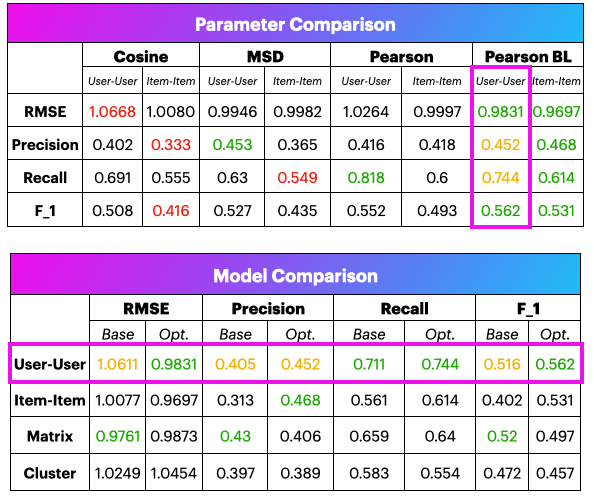

 Pearson Baseline parameter gave us the best optimized model for both user-user and item-item. MSD had the highest precision score for user-user. Pearson had the highest recall rate for user-user. The worse performing parameter was cosine. 

 We can try to further improve the performance of these models using hyperparameter tuning even more those who did not perform as well.

 We can also combine different recommendation techniques to build hybrid recommendation systems.

- **Proposal for the final solution design** - What model do you propose to be adopted? Why is this the best solution to adopt?

 The overall best model to use is user-user optimized since it has the highest F-1 Score and recall using the Pearson Baseline parameter despite having a lower precision rate than item-item optimized, as well as, RMSE.

 Additionally, the content based recommendations system worked well since it is text based data and can recommend the exact song name for the listener, versus with an ID number. 
 
 Moving forward, would like to explore to build a hybrid recommendations system between user-user, item-item, and content based. User-user because the precision scores and F_1 scores performed the best and content based would be good to use to capitilize on its text data processing ability.